In [3]:
import numpy as np
import pandas as pd
import os
import json
from pathlib import Path
import matplotlib.pyplot as plt


dir_project = os.getcwd()
model = "AST"
dir_input = os.path.join(dir_project, "results", f"results_{model}")
dir_output = os.path.join(dir_project, "figure")

Load selected classification result file. Adjust for correct time zone (minus 4 hours)

In [2]:
file_result = "results_AST_primary1 - including ultrasonic.csv"
name_location = Path(file_result).stem.split("_")[-1]

df = pd.read_csv(os.path.join(dir_input, file_result))
id_to_label = json.load(open(os.path.join(dir_project, "id_to_label.json")))

df["result"] = df["result"].apply(
    lambda x: [float(i.replace("'", "")) for i in x[1:-1].split(",")]
)

df["result"] = df["result"].apply(
    lambda x: [(id_to_label[str(i)], p) for i, p in enumerate(x)]
)

df["result"] = df["result"].apply(lambda x: sorted(x, key=lambda x: x[1], reverse=True))

df["result"] = df["result"].apply(lambda x: sorted(x, key=lambda x: x[1], reverse=True))

df["result"] = df["result"].apply(lambda x: {k: v for k, v in x})

# %
from datetime import datetime, timedelta

df["datetime_non_adj_str"] = df["filename"].apply(lambda x: x[:-4])
df["datetime_nonadj"] = df["datetime_non_adj_str"].apply(
    lambda x: datetime.strptime(x, "%Y%m%d_%H%M%S")
)
df["datetime"] = df["datetime_nonadj"].apply(lambda x: x - timedelta(hours=4))
df["datetime_str"] = df["datetime"].apply(lambda x: x.strftime("%Y%m%d_%H%M%S"))
df["year"] = df["datetime"].apply(lambda x: x.year)
df["month"] = df["datetime"].apply(lambda x: x.month)
df["day"] = df["datetime"].apply(lambda x: x.day)
df["hour"] = df["datetime"].apply(lambda x: x.hour)
df["minute"] = df["datetime"].apply(lambda x: x.minute)
df["second_start"] = df["start_time"]
df["second_end"] = df["end_time"]
df["datetime_sec_str"] = df.apply(
    lambda x: f"{x['datetime_str']}_{x['second_start']}_{x['second_end']}", axis=1
)
df["date_str"] = df["datetime"].apply(lambda x: x.strftime("%Y%m%d"))

df.sort_values(by=["datetime_str", "second_start"], inplace=True)



Plot raw probability

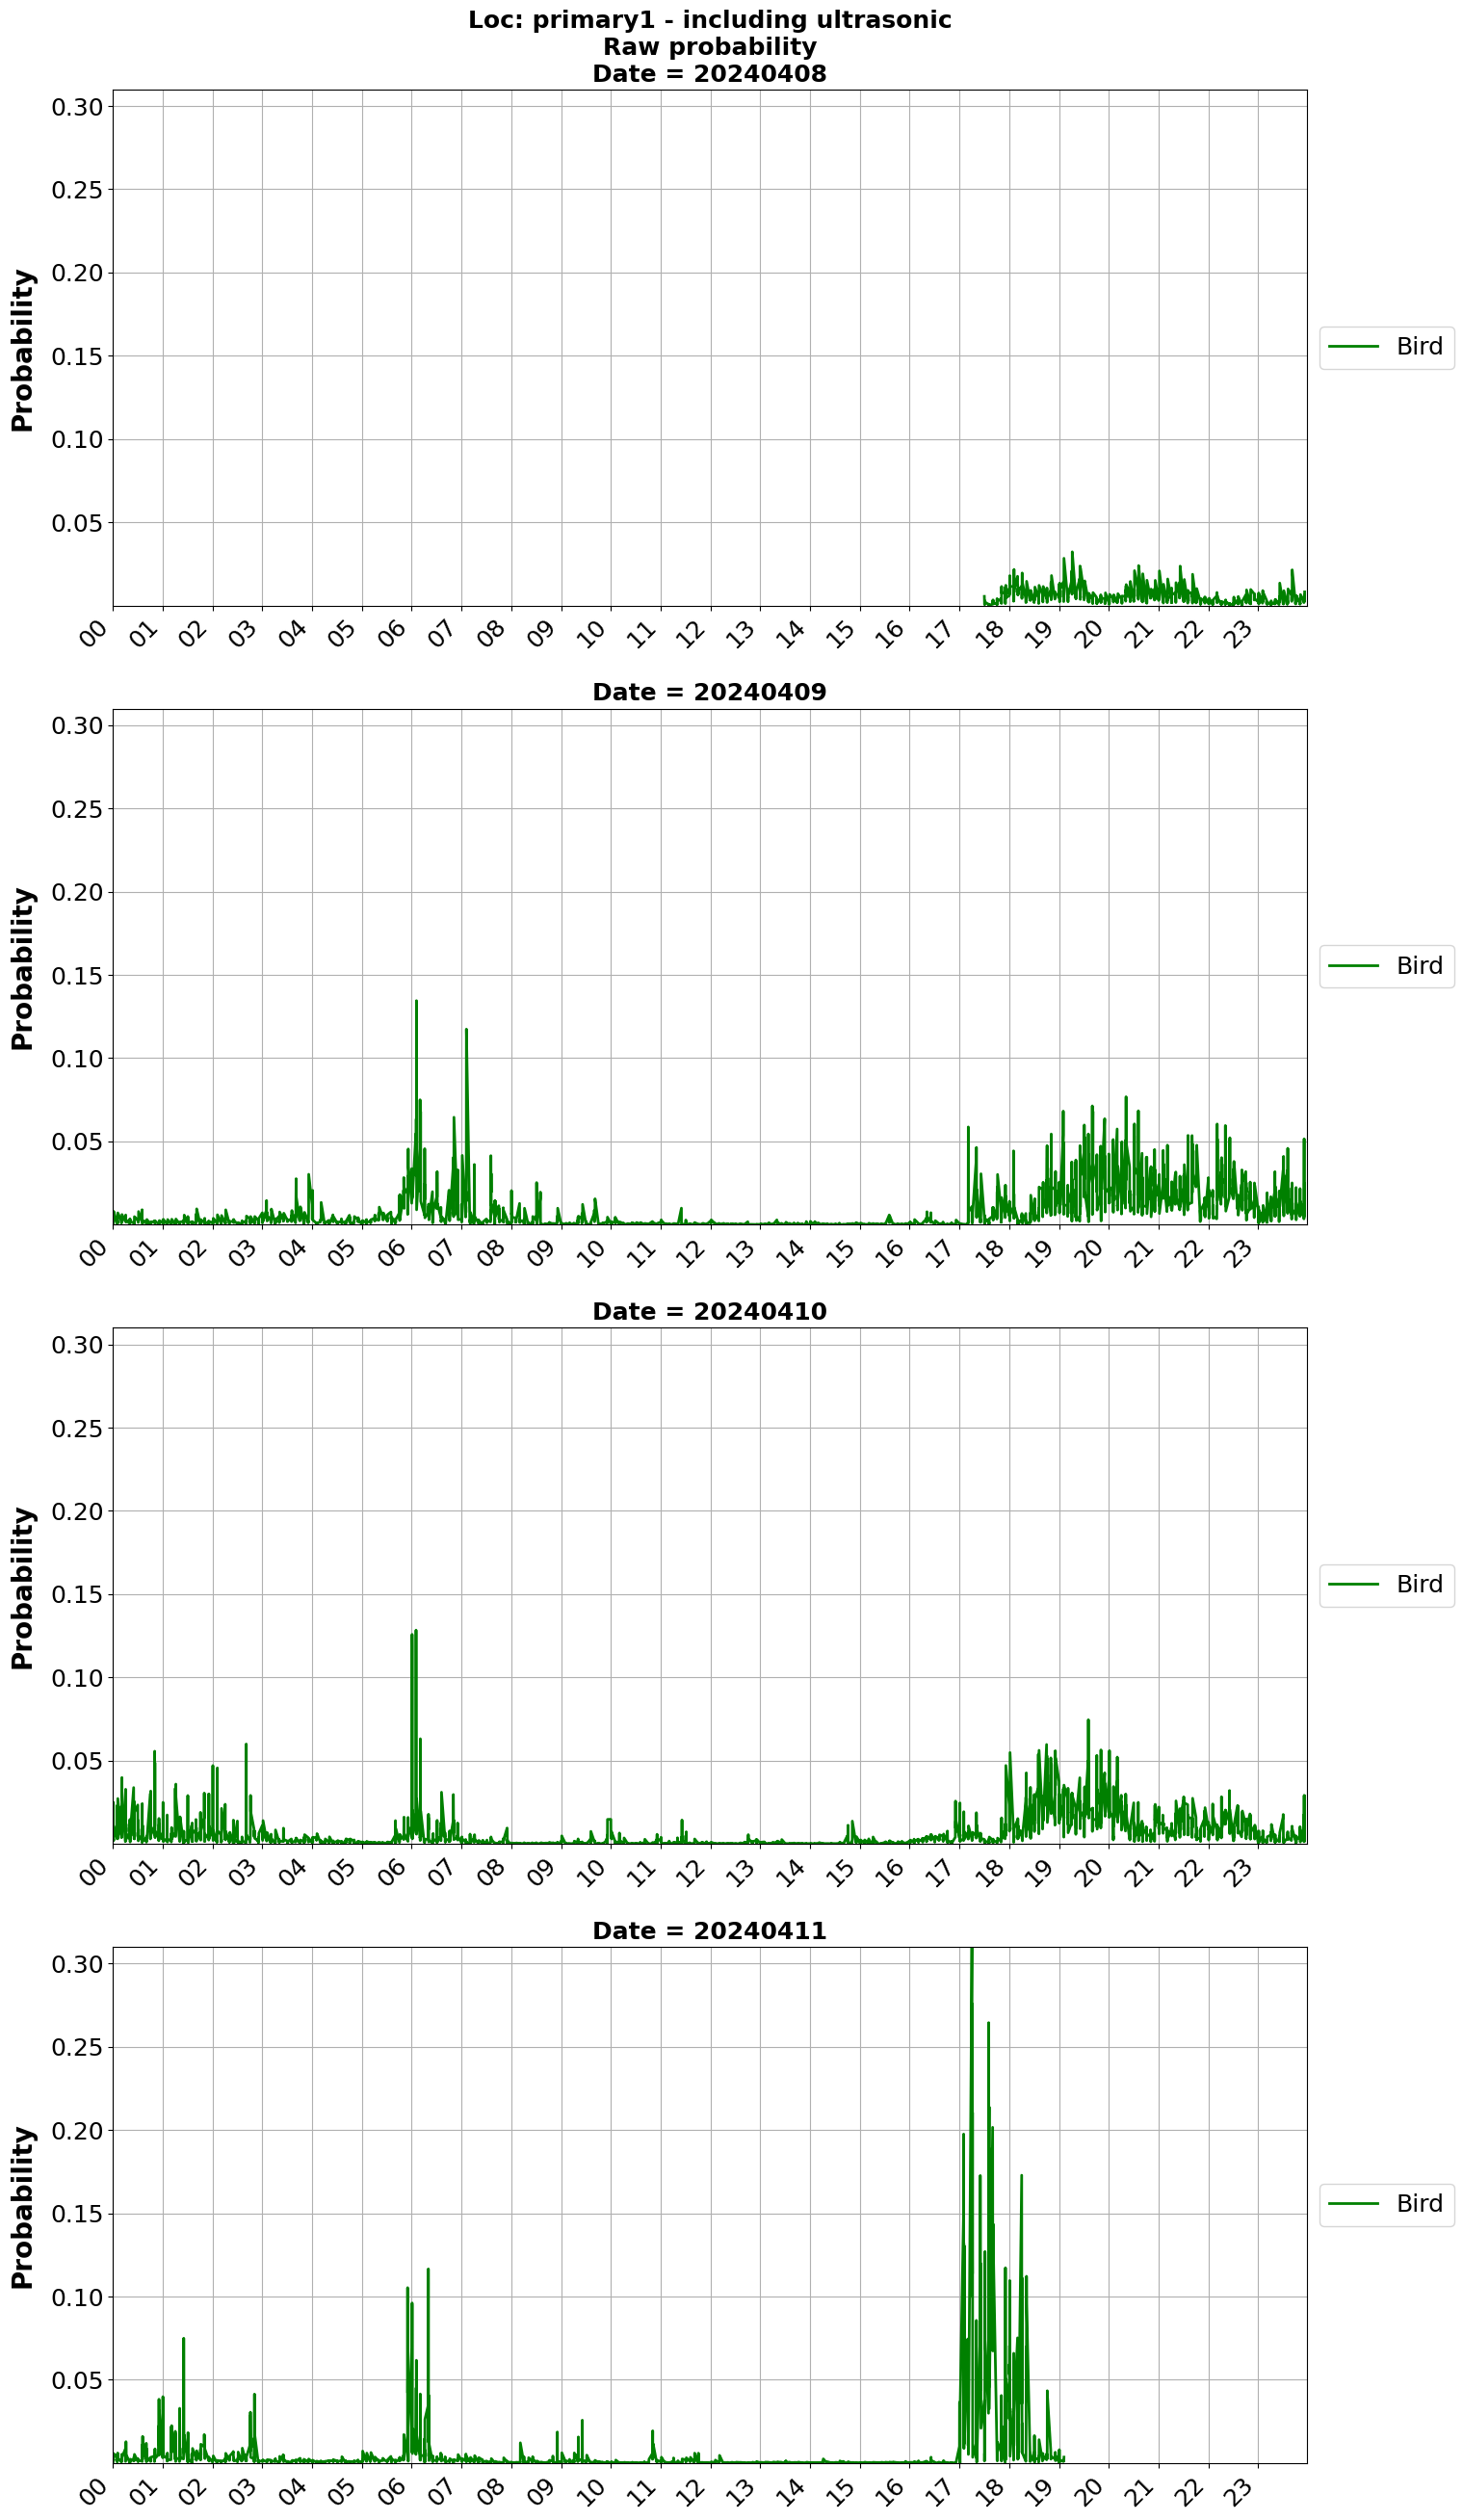

In [4]:
dict_color = {
        "Bird": "green",
        "Insect": "cyan",
        "Cricket": "orange",
        "Caw": "red",
        "Animal": "blue",
        "Frog": "magenta",
        "Speech": "black",
    }

# select label to be displayed
label_chosen = "Bird"


SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
import matplotlib.dates as mdates

list_date_unique = df["date_str"].unique()

fig = plt.figure(figsize=[16, 8*len(list_date_unique)])
all_data = []
for i_date in np.arange(len(list_date_unique)):
    date_chosen = list_date_unique[i_date]
    df_crop = df[df["date_str"] == date_chosen].copy()
    list_result = df_crop["result"].values
    list_prob = [x[label_chosen] for x in list_result]
    all_data.append(list_prob)
all_y_values = np.concatenate(all_data)
global_min_y = np.min(all_y_values)
global_max_y = np.max(all_y_values)

for i_date in np.arange(len(list_date_unique)):
    date_chosen = list_date_unique[i_date]
    df_crop = df[df["date_str"] == date_chosen].copy()
    list_result = df_crop["result"].values
    list_prob = [x[label_chosen] for x in list_result]
    list_datetime = df_crop["datetime"].values.astype("M8[ms]").astype(datetime)
    list_second_start = df_crop["second_start"].values
    list_datetime_start = [
        np.datetime64(
            list_datetime[i] + timedelta(seconds=int(list_second_start[i]))
        )
        for i in range(len(df_crop))
    ]
    date_array = list_datetime_start
    ax = fig.add_subplot(len(list_date_unique), 1, i_date + 1)
    ax.plot(
        list(pd.to_datetime(date_array)),
        list_prob,
        color=dict_color[label_chosen],
        label=label_chosen,
        linewidth=2,
    )
    ax.set_ylim([global_min_y, global_max_y])
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_ylabel("Probability", labelpad=10, fontweight="bold")
    if i_date == 0:
        ax.set_title(
            f"Loc: {name_location}\nRaw probability\nDate = {date_chosen}", fontweight="bold"
        )
    else:
        ax.set_title(f"Date = {date_chosen}", fontweight="bold")        
    # Define the formatter to only show the hour
    hours = mdates.DateFormatter("%H")

    ax.set_xlim(
        np.datetime64(
            f"{date_chosen[0:4]}-{date_chosen[4:6]}-{date_chosen[6:8]}T00:00"
        ),
        np.datetime64(
            f"{date_chosen[0:4]}-{date_chosen[4:6]}-{date_chosen[6:8]}T23:59"
        ),
    )

    # Apply the formatter to the x-axis
    ax.xaxis.set_major_formatter(hours)

    # Optionally, set the locator to show more hours for better visualization
    locator = mdates.HourLocator(interval=1)
    ax.xaxis.set_major_locator(locator)

    # Rotate date labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    plt.grid()



Aggreate windows within an audio file. 2 aggregating method: average across windows or get maximum values across windows.

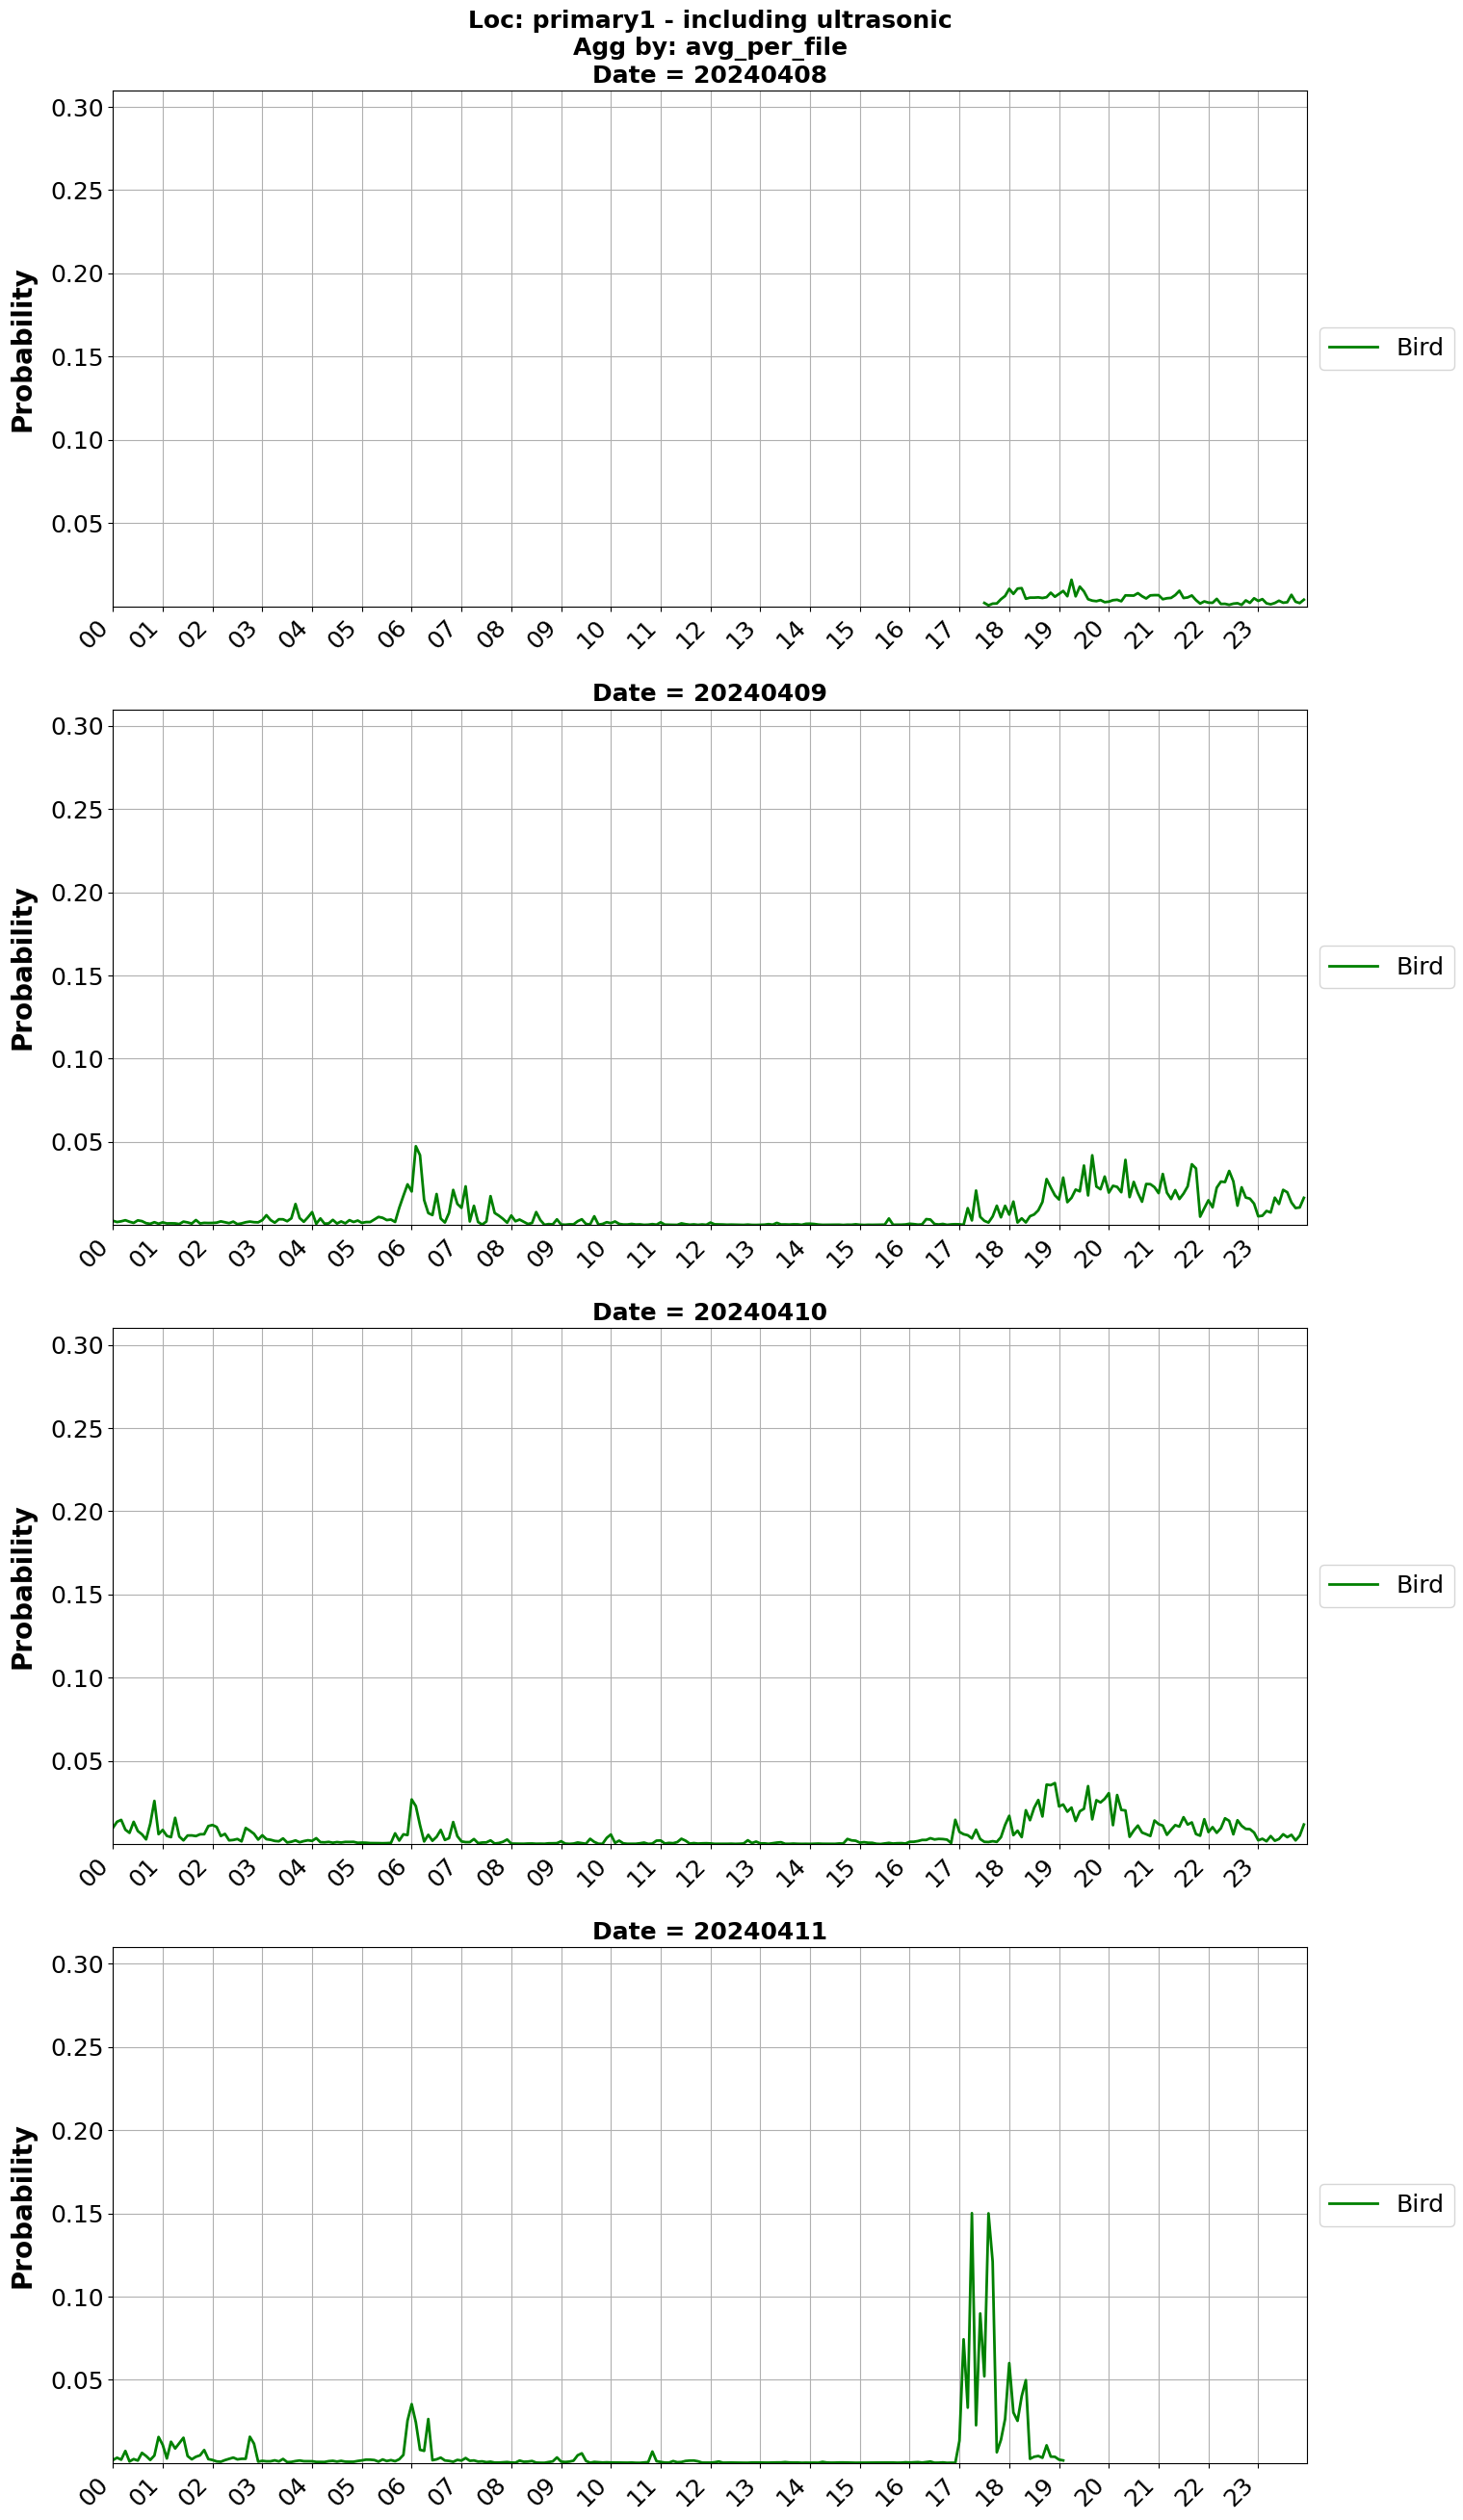

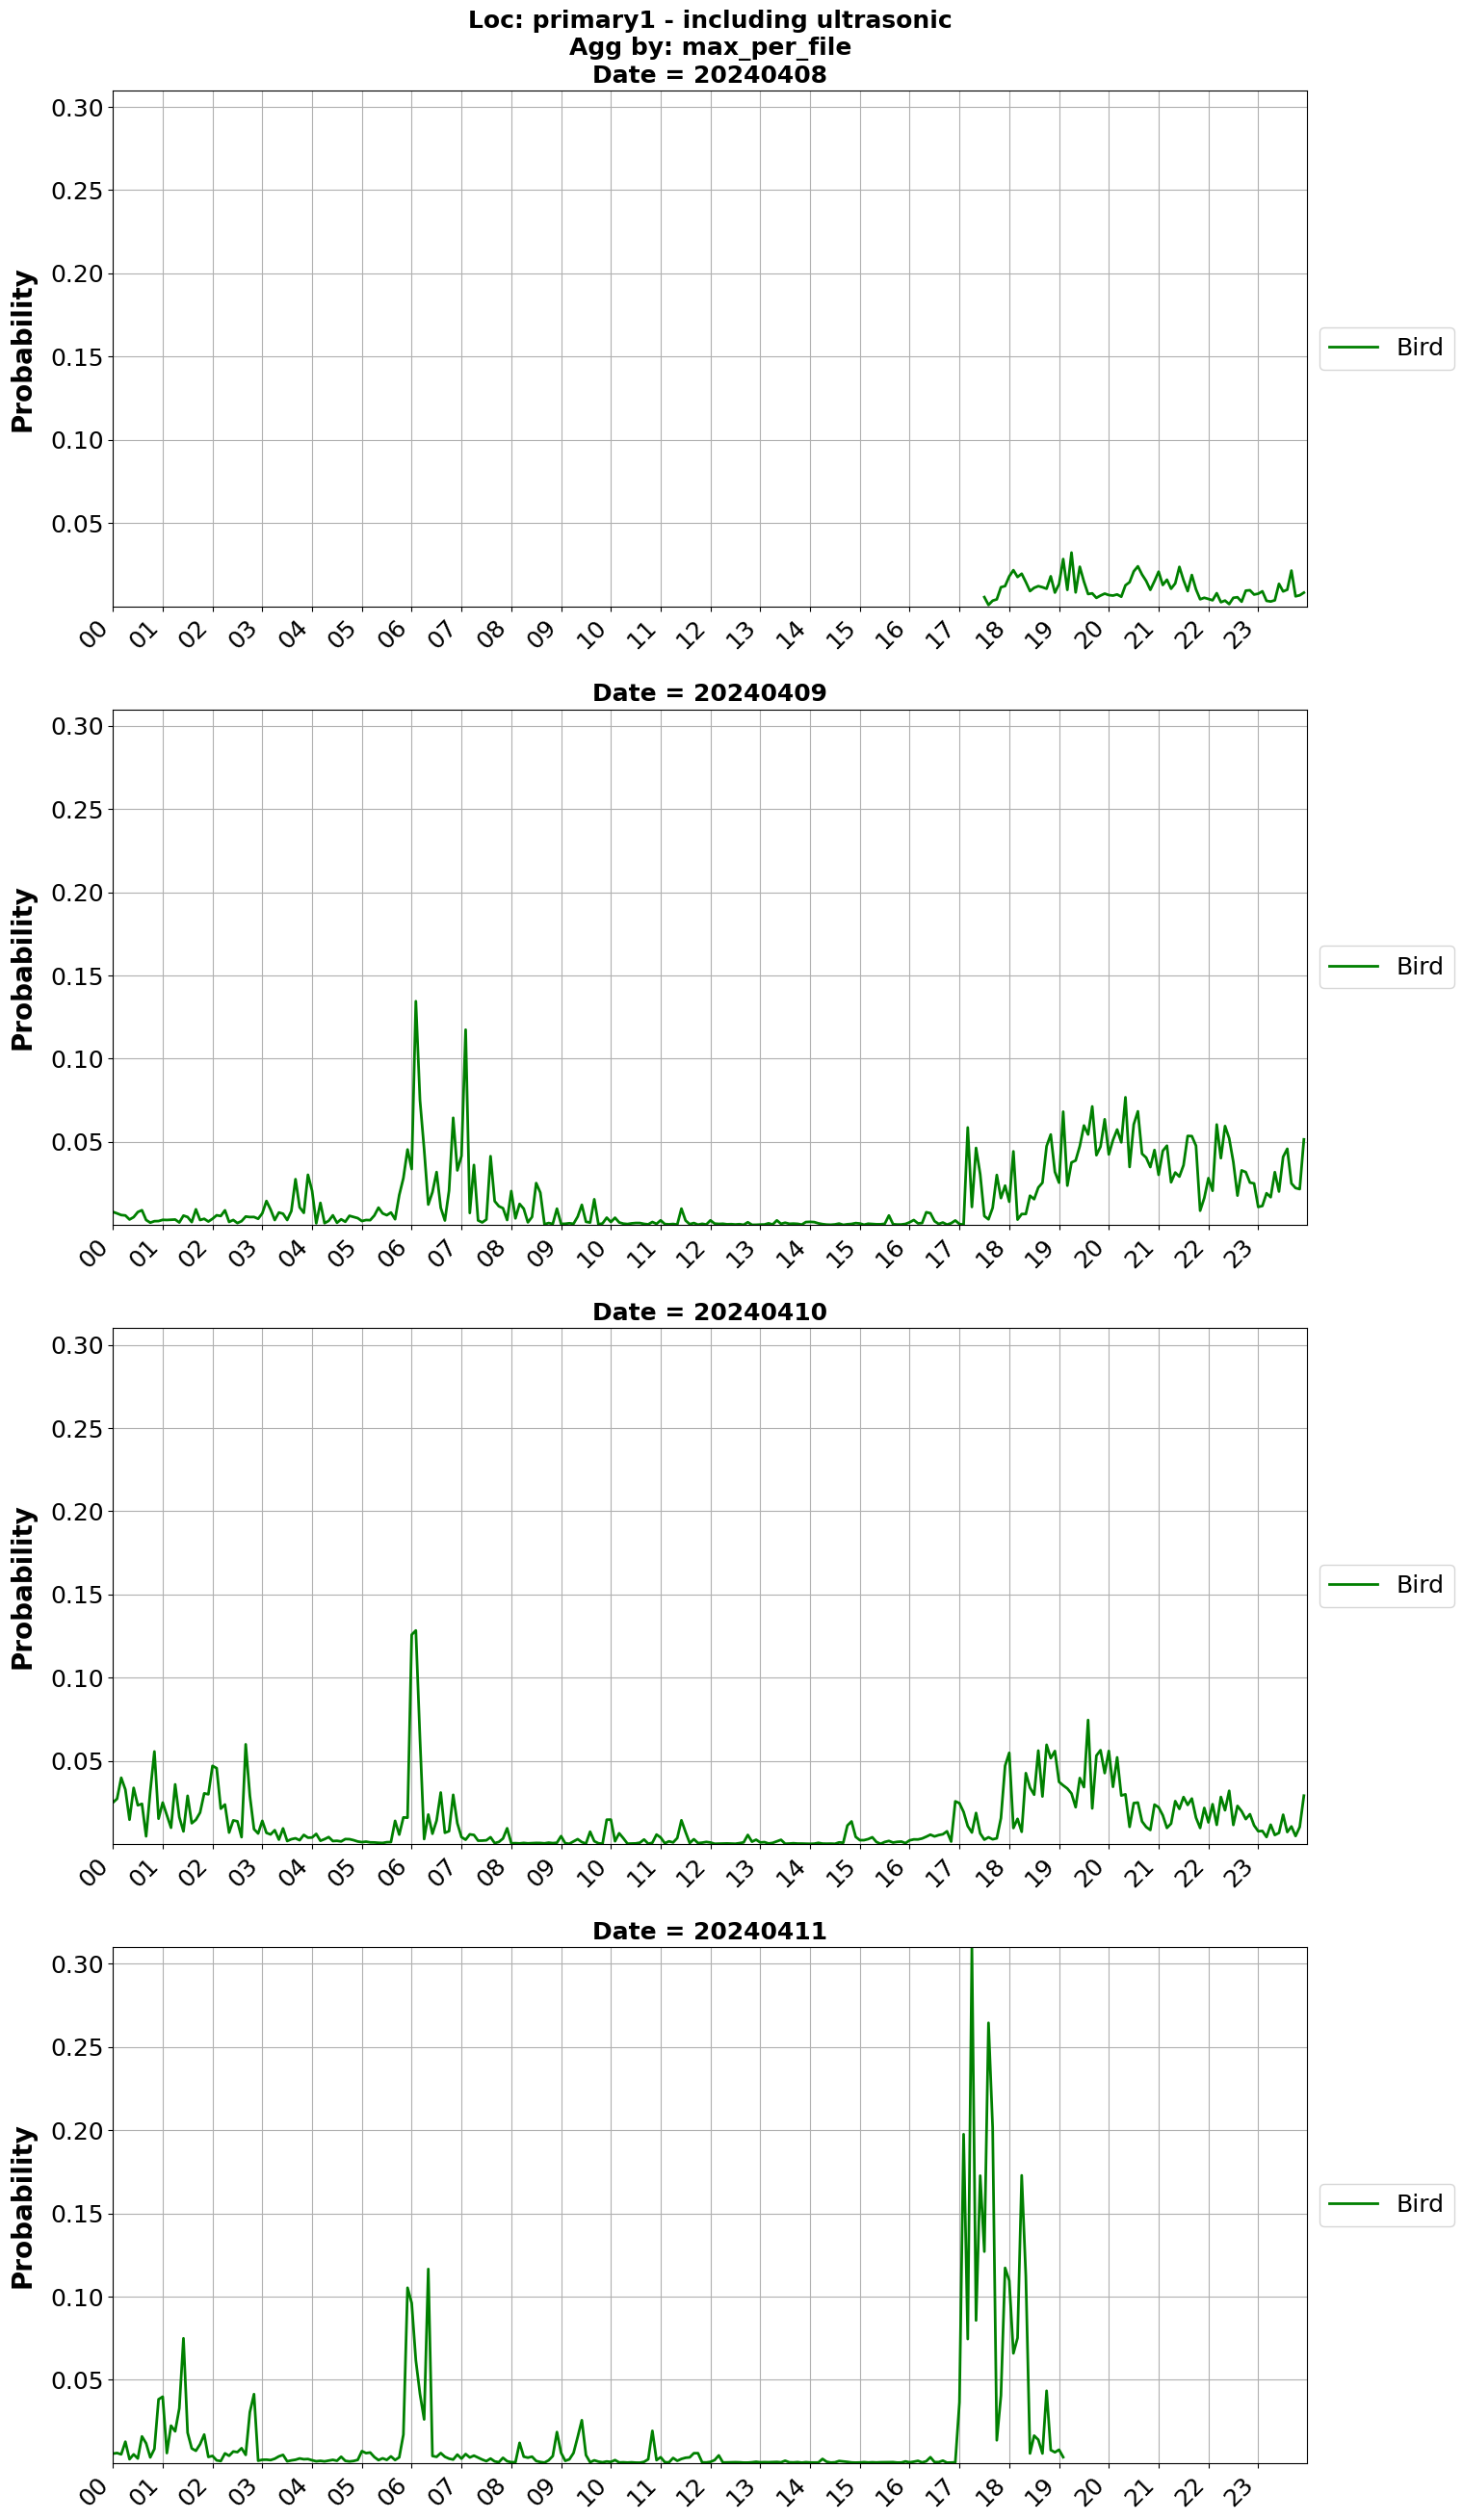

In [7]:
# select label to be displayed
label_chosen = "Bird"

def get_dict_avg(data_list):
    # Calculate the sum of values for each key
    sum_values = {key: sum(entry[key] for entry in data_list) for key in data_list[0]}
    # Calculate the number of entries
    num_entries = len(data_list)

    # Calculate the average for each key
    average_values = {key: sum_values[key] / num_entries for key in sum_values}
    return average_values


def get_dict_max(data_list):
    max_values = {}

    for key in data_list[0]:
        max_values[key] = float(
            "-inf"
        )  # Initialize with negative infinity as initial maximum value

    # Update max_values with the maximum value for each key across all dictionaries
    for entry in data_list:
        for key, value in entry.items():
            max_values[key] = max(max_values[key], value)
    return max_values

df_group = df[["filename", "result"]].groupby("filename", as_index=False).agg(list)
df_group["datetime_non_adj_str"] = df_group["filename"].apply(lambda x: x[:-4])
df_group["datetime_nonadj"] = df_group["datetime_non_adj_str"].apply(
    lambda x: datetime.strptime(x, "%Y%m%d_%H%M%S")
)
df_group["datetime"] = df_group["datetime_nonadj"].apply(
    lambda x: x - timedelta(hours=4)
)
df_group["datetime_str"] = df_group["datetime"].apply(
    lambda x: x.strftime("%Y%m%d_%H%M%S")
)
df_group["date_str"] = df_group["datetime"].apply(lambda x: x.strftime("%Y%m%d"))

for type_result in ["avg_per_file","max_per_file"]:
    if type_result == "avg_per_file":
        list_result_agg = [get_dict_avg(x) for x in df_group["result"].values]
    elif type_result == "max_per_file":
        list_result_agg = [get_dict_max(x) for x in df_group["result"].values]
    list_datetime = df_group["datetime"].values.astype("M8[ms]").astype(datetime)
    df_group[type_result] = list_result_agg
    # %


    list_date_unique = df_group["date_str"].unique()

   
    fig = plt.figure(figsize=[16, 8*len(list_date_unique)])

    all_data = []
    for i_date in np.arange(len(list_date_unique)):
        date_chosen = list_date_unique[i_date]
        df_crop = df[df["date_str"] == date_chosen].copy()
        list_result = df_crop["result"].values
        list_prob = [x[label_chosen] for x in list_result]
        all_data.append(list_prob)
    all_y_values = np.concatenate(all_data)
    global_min_y = np.min(all_y_values)
    global_max_y = np.max(all_y_values)

    for i_date in np.arange(len(list_date_unique)):
        date_chosen = list_date_unique[i_date]
        df_crop = df_group[df_group["date_str"] == date_chosen].copy()
        # plot very points
        list_label = [label_chosen]
        list_result = df_crop[type_result].values
        list_prob = [x[label_chosen] for x in list_result]
        list_datetime = df_crop["datetime"].values.astype("M8[ms]").astype(datetime)
        date_array = list_datetime
        ax = fig.add_subplot(len(list_date_unique), 1, i_date + 1)
        i = list_label.index(label_chosen)
        ax.plot(
            list(pd.to_datetime(date_array)),
            list_prob,
            color=dict_color[label_chosen],
            label=label_chosen,
            linewidth=2,
        )
        ax.set_ylim([global_min_y, global_max_y])

        ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
        ax.set_ylabel("Probability", labelpad=10, fontweight="bold")
        if i_date == 0:
            ax.set_title(
                f"Loc: {name_location}\nAgg by: {type_result}\nDate = {date_chosen}", fontweight="bold"
            )
        else:
            ax.set_title(f"Date = {date_chosen}", fontweight="bold")
        # Define the formatter to only show the hour
        hours = mdates.DateFormatter("%H")

        ax.set_xlim(
            np.datetime64(
                f"{date_chosen[0:4]}-{date_chosen[4:6]}-{date_chosen[6:8]}T00:00"
            ),
            np.datetime64(
                f"{date_chosen[0:4]}-{date_chosen[4:6]}-{date_chosen[6:8]}T23:59"
            ),
        )

        # Apply the formatter to the x-axis
        ax.xaxis.set_major_formatter(hours)

        # Optionally, set the locator to show more hours for better visualization
        locator = mdates.HourLocator(interval=1)
        ax.xaxis.set_major_locator(locator)

        # Rotate date labels for better readability
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
        plt.grid()